In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skopt.learning import ExtraTreesRegressor as opt_ETR
from scipy.stats import norm
import random
import warnings
warnings.filterwarnings("ignore")

random.seed(1126)
np.random.seed(1126)

In [2]:
data = pd.read_csv('data/proposed.csv').drop('Unnamed: 0', axis = 1)

data = data.fillna(0)
data.loc[:, "Contact time, s"] = np.log10(data.loc[:, "Contact time, s"])
idx = random.sample(range(len(data)), k = 30)
feat = data.loc[idx, "Li":'Contact time, s']
target = data.loc[idx, 'Y(C2), %']
feat.index = np.arange(30)
target.index = np.arange(30)

desc = pd.read_csv("data/Descriptors.csv", skiprows=[0], index_col="symbol")
desc.drop(
    [
        "Unnamed: 0",
        "AN",
        "AW",
        "name",
        "period",
        "ionic radius",
        "covalent radius",
        "group",
        "VdW radius",
        "m. p.",
        "b. p.",
        "crystal radius",
        "a x 106 ",
        "atomic radius",
        "Heat capacity ",
        "l",
        "ionization enegy ",
        "electron affinity ",
        "VE",
        "Surface energy ",
    ],
    axis=1,
    inplace=True,
)
desc = desc.fillna(desc.mean())
for i in range(8):
    feat = feat.drop([f"{i+1}_ionization enegy", f"{i+1}_AW", f"{i+1}_atomic radius" ], axis =1)

comp =feat.loc[:,"Li":"Bi"].columns
prep = feat.loc[:,'Impregnation':'Pechini method'].columns
cond = feat.loc[:, 'Temperature, K':'Contact time, s'].columns
prom = feat.loc[:, 'Promotor_Cl':'Promotor_F'].columns
metal= feat.loc[:, '1_electronegativity':'8_density'].columns
cols = list(prep) + list(cond)
columns = list(comp) + list(prom) + list(prep) + list(cond)
random_state =1126

In [3]:
def opt_function(x, y ,model, desc,random_state =1126):
    """
    各実験ずみの点に対して4回近傍の探索を行い最もEIの高かった組成実験条件を返す
    """
    x_ch = data
    xx = x.iloc[:,:-2]
    neighbor = pd.DataFrame(index = x.columns)
    for key, row in xx.iterrows():
        count = 0
        nei_cand = []
        #print('ind={0}'.format(key))
        if x.loc[key, 'make_nei'] == True:
            
            additional = ["Add"]*100


            cols = list(additional) + list(prom) + list(prep) + list(cond)


            for count in range(30):
                change_f = random.choice(cols)
                row_ch = row.copy()
                """
                ここからが鈴木氏作成プログラムとの差分
                
                """

                if change_f == "Add":
                    
                    #全ての元素を０に初期化
                    row_ch[comp] = 0
                    
                    for i in range(8):
                        #i-1回目の処理のデータを保存
                        row_sub = row_ch
                        
                        #大きい方からchange_f番目の元素に紐ずくaddtional descriptorを一括での局所的探索
                        change_col= list([f"{i+1}_electronegativity", f"{i+1}_delta_fus H",f"{i+1}_density"])
                        a = row_ch[change_col] - x_ch[change_col].min()
                        b = x_ch[change_col].max() - x_ch[change_col].min()
                        v = a/b
                        
                        v = np.minimum(v, 1.0)
                        
                        p = np.array([-1])
                        while (p <0).any() | (p>1).any():
                            p = random.normalvariate(v, 0.2)
                            
                        p = p * b + x_ch[change_col].min()
                        row_ch[change_col] = p
                        p = np.array(p)
                        
                        #alpha = x1_x0/x1_2#２次関数の軸の位置
                        alpha = desc.apply(lambda u: np.dot(u, p)/np.dot(u, u), axis = 1)
                        #εの値が小さい元素名を返す
                        epsilon = desc.mul(alpha, axis=0).apply(lambda u: np.dot(u-p, u-p), axis=1).sort_values().index

                    
                        for i in range(0, len(epsilon)):
                            #軸が100以下をみたし、　組成元素が0ではない元素に変換する
                            if (alpha[epsilon[i]] < 100) & (row_ch[epsilon[i]] == 0):
                                row_ch[epsilon[i]] = alpha[epsilon[i]]
                                break
                        
                        #組成の合計が100を超えると処理を抜ける        
                        if row_ch[comp].sum() >= 100:
                            break
                        
                    # 100によりちかい組成を選択肢、標準化
                    if  abs(100 -row_ch[comp].sum()) > abs(100-row_sub[comp].sum()):
                        row_ch[comp] =  (row_sub[comp] * 100) / row_sub[comp].sum()
                        
                    else:
                        row_ch[comp] =  (row_ch[comp] * 100) / row_ch[comp].sum()
                        
                        
                    """
                    差分ここまで
                    """

                elif change_f in cond:
                    a = np.array(row_ch[change_f]) - x_ch[change_f].min()
                    b = x_ch[change_f].max() - x_ch[change_f].min()
                    v = a / b
                    p = -1
                    while (p < 0) | (p > 1):
                        p = random.normalvariate(v, 0.2)


                    p = p * b + x_ch[change_f].min()
                    row_ch[change_f] = p

                elif change_f in prep:
                    row_ch[change_f] = 1
                    ind = set(prep) - {change_f}
                    row_ch[ind] = 0



                nei_cand.append(row_ch)
                

                
            

            nei_cand = pd.DataFrame(nei_cand, index =np.arange(len(nei_cand)))
            temp = comp_times_base(nei_cand.loc[:,comp],desc.loc[comp].T,sort=True,times=True)
            temp = pd.DataFrame(temp)
            temp = temp.iloc[:, :24].fillna(0)
            temp.columns = metal
            nei_cand = pd.concat([nei_cand.loc[:,comp],temp, nei_cand.loc[:, prom], nei_cand.loc[:,prep], nei_cand.loc[:, cond]], axis = 1)
            
            mu, sigma = model.predict(np.array(nei_cand.loc[:,"1_electronegativity":]), return_std=True)
            ind = y.values.argmax()
            cur_max = y.iloc[ind]
            ei = EI(mu, sigma, cur_max)
            ind = np.argmax(ei)
            cand = nei_cand.iloc[ind].copy()
            cand['ei'] = ei[ind]
            if x.loc[key, 'ei'] < cand['ei']:
                cand['make_nei'] = True
                neighbor = pd.concat([neighbor, cand], axis = 1)
            else:
                x.loc[key, 'make_nei'] = False
                neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                
        else:
            neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                                                    
    print('-----------')
    
    neighbor = neighbor.T
    neighbor.index = x.index
    return neighbor



def smac(model, init_x, init_y, roen_func, desc, random_state = 1126):
    """
    SMAC　のメインプログラム(鈴木氏作成)
    """
    cur_max = init_y.max()
    sub_x = init_x
    init_x = init_x.loc[:,"1_electronegativity":]
    model.fit(np.array(init_x), np.array(init_y))
    print(model)
    mu, sigma =  posterior(np.array(init_x), np.array(init_x), init_y, model)
    ei =  EI(mu, sigma, init_y.max())
    ei = pd.Series(ei, index = init_x.index, name = 'ei')
    make_nei =pd.Series(True, index=init_x.index, name='make_nei')
    next_x = pd.concat([sub_x, ei, make_nei], axis =1)
    while next_x['make_nei'].sum() != 0:
        next_x = roen_func(next_x, init_y, model, desc)
        print(next_x['make_nei'].sum())
        
    cand = next_x
        
    return cand

def posterior(x, p_x, p_y, model):
    """
    EIを計算する上でのμならびにσの計算(鈴木氏作成)
    """
    if len(p_x.shape) == 1:
        model.fit(p_x.reshape(-1, 1), p_y)
        mu, sigma = model.predict(x.reshape(-1, 1), return_std = True)
    else:
        model.fit(p_x, p_y)
        mu, sigma = model.predict(x, return_std = True)
    ind = np.where(sigma == 0)
    sigma[ind] = 1e-5
    return mu, sigma

def EI(mu, sigma, cur_max):
    """
    EIの計算(鈴木氏作成)
    """
    Z = (mu - cur_max)/ sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z)
    return ei


def comp_times_base(comp, base, sort=False, times=True, attention=False):
    """
    elementからaddtional descriptorに変更するプログラム(鈴木氏作成)
    """
    count = 0
    for key, rows in comp.iterrows():
        
        stack = np.vstack((rows, base))
        if times == True:
            time = np.array(base) * np.array(rows)
            stack = np.vstack((rows, time))

        if sort == True:
            stack = pd.DataFrame(stack).sort_values(
                [0], ascending=False, axis=1)

        stack = pd.DataFrame(stack).iloc[1:, :]
        stack = np.array(stack)

        if count == 0:
            if attention:
                res = np.sum(stack, axis=1)
            else:
                res = np.array(stack.T.flatten())

            count += 1
        else:
            if attention:
                res = np.vstack((res, np.sum(stack, axis=1)))
            else:
                res = np.vstack((res, np.array(stack.T.flatten())))

            count += 1
    return res

## SMAC

In [16]:
%%time
 model = opt_ETR(n_estimators = 500, random_state = 1126, n_jobs = -1)
cand = smac(model, feat, target,opt_function, desc)


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_samples_leaf=1,
                    min_samples_split=2, min_variance=0.0,
                    min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                    oob_score=False, random_state=1126, verbose=0,
                    warm_start=False)
-----------
30.0
-----------
28.0
-----------
23.0
-----------
13.0
-----------
11.0
-----------
7.0
-----------
4.0
-----------
1.0
-----------
0
CPU times: user 5min 3s, sys: 1.39 s, total: 5min 4s
Wall time: 5min 15s


## 以下クラスタリング

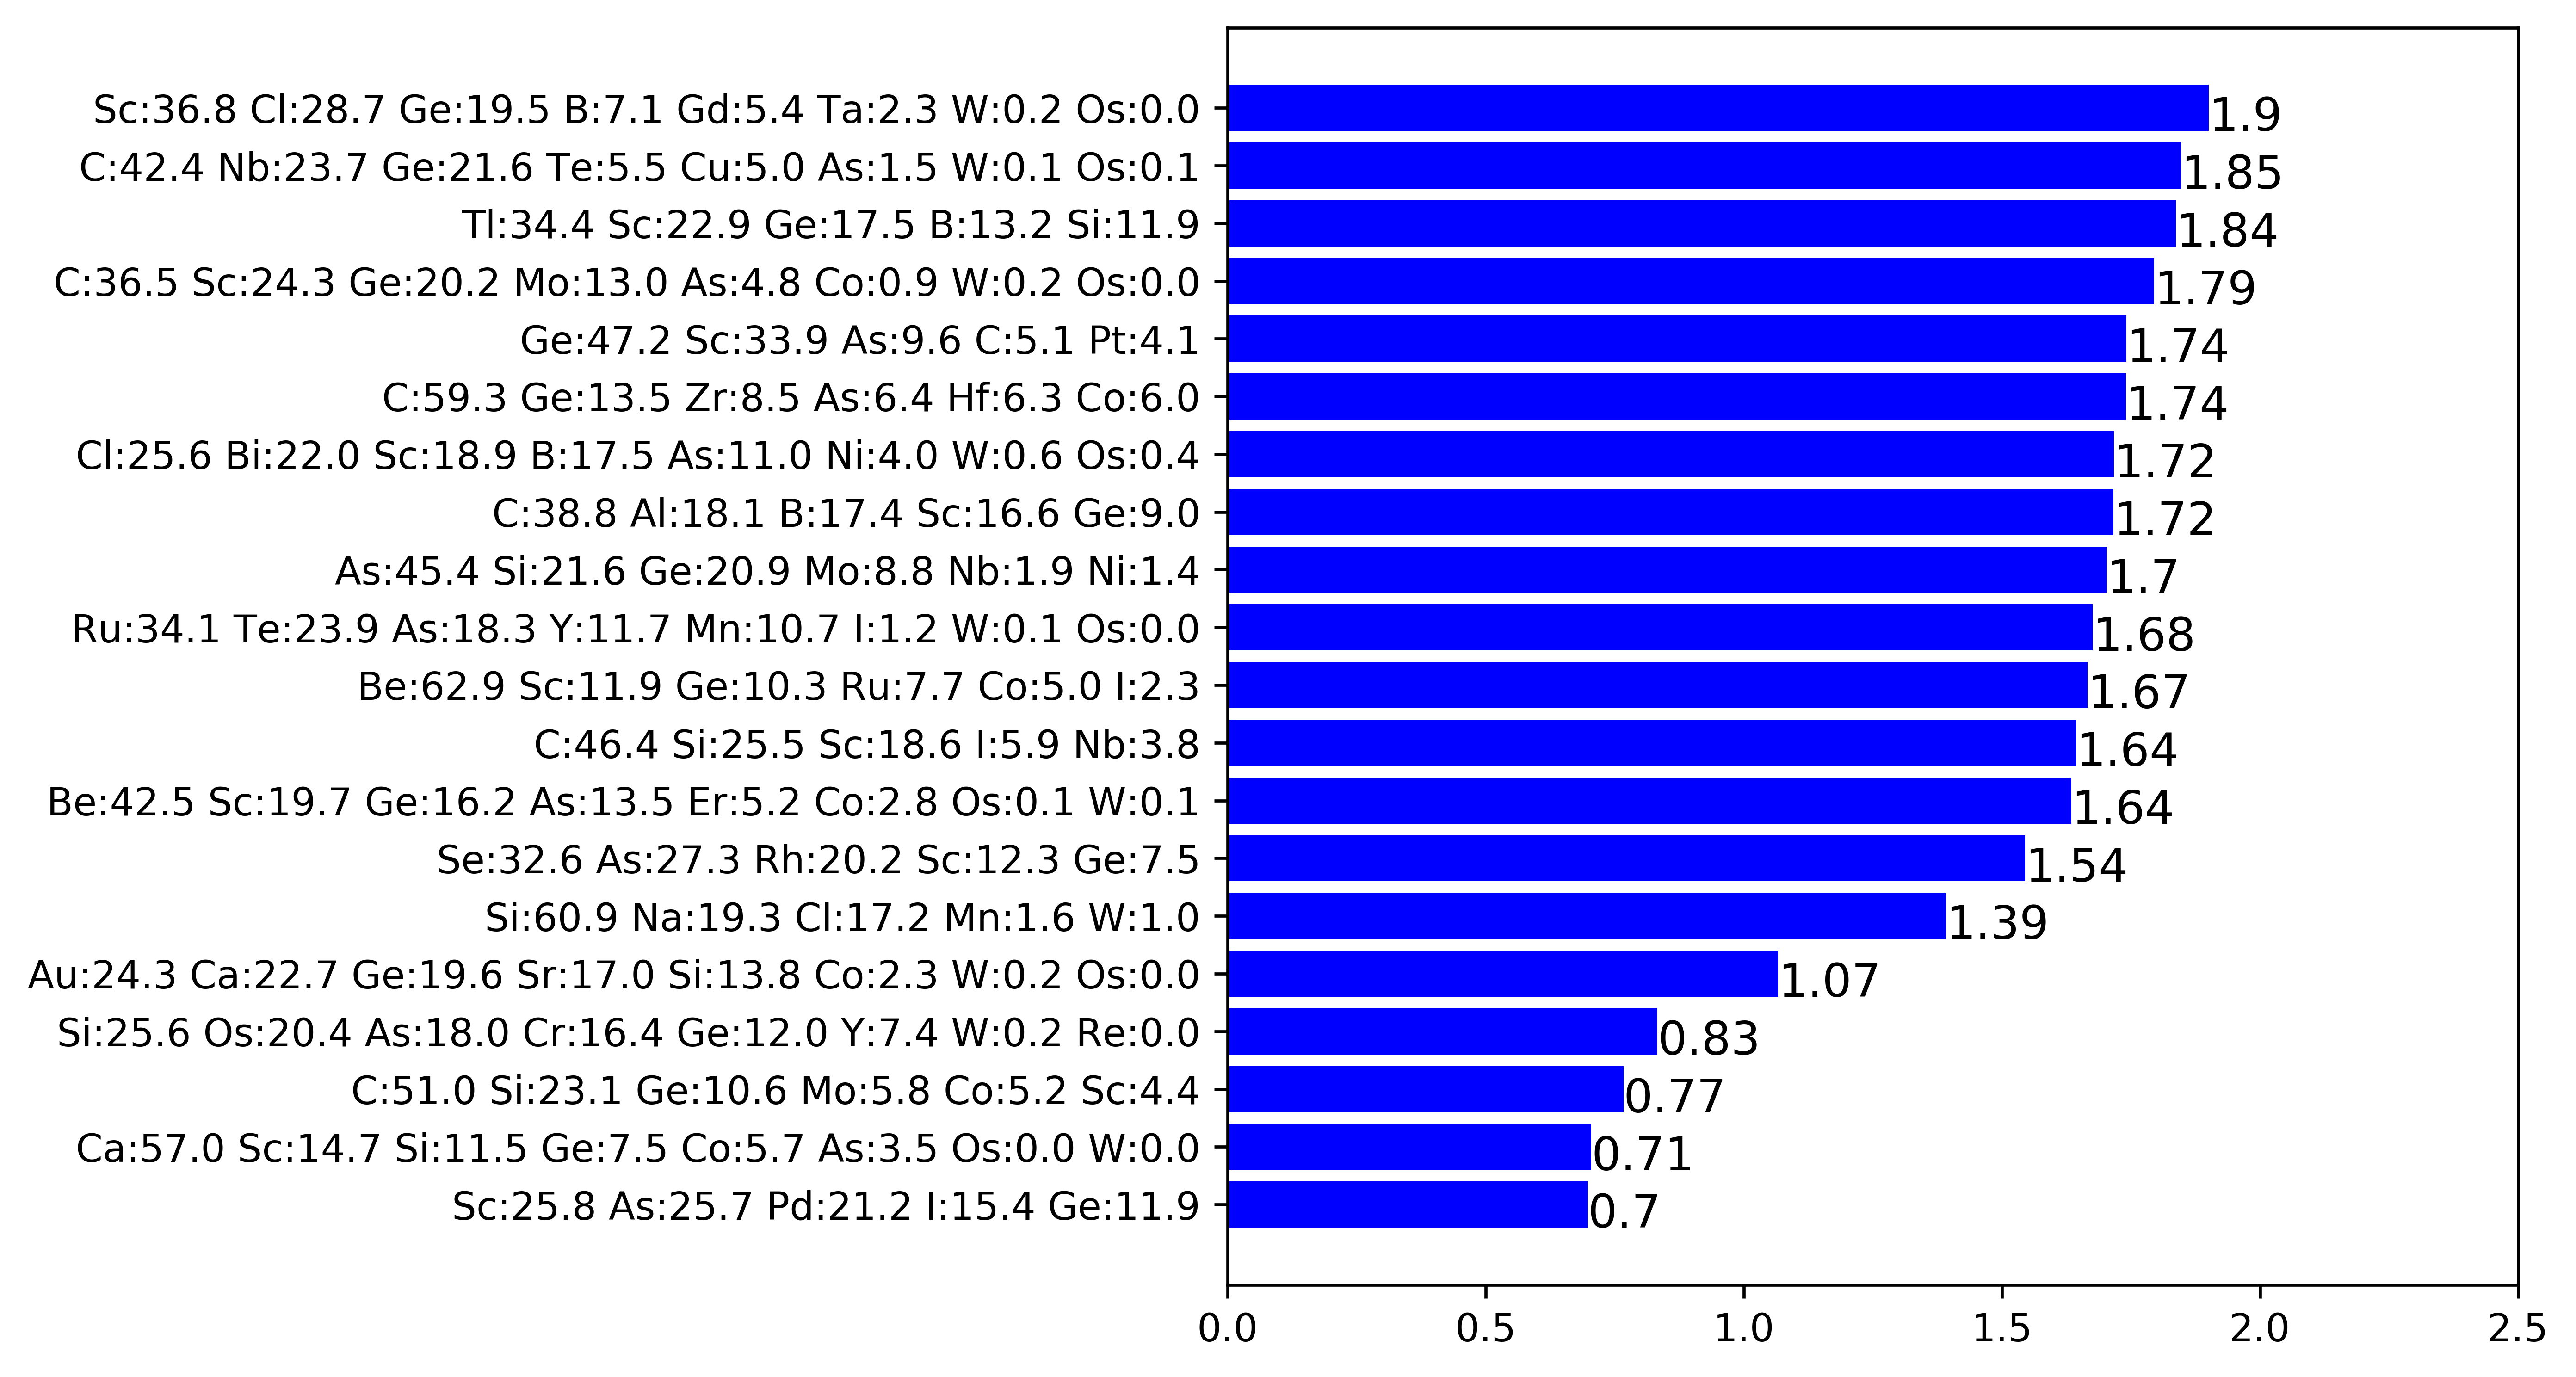

In [18]:
#feat.loc[:,'Contact time, s'] = np.log10(feat.loc[:,'Contact time, s'])
from sklearn.cluster import KMeans
feat = feat.loc[:,"1_electronegativity":"Contact time, s"]
model = opt_ETR(n_estimators = 500, n_jobs = -1)
k = KMeans(n_clusters=30, random_state=1126)
cluster = k.fit_predict(cand.iloc[:,:-1])
cluster = pd.Series(cluster, index=cand.index, name='cluster')
cand = pd.concat([cand,cluster], axis=1)
model.fit(feat, target)
pred_y = model.predict(cand.loc[:,"1_electronegativity":"Contact time, s"])
pred_y = pd.Series(pred_y, index = cand.index, name = 'pred_y')
cand = pd.concat([cand,pred_y], axis = 1)
#choose point which has most better ei value in each cluster
clus_high = cand.sort_values(by=['cluster','ei']).drop_duplicates(subset=['cluster'],keep='last')
clus_high = clus_high.sort_values(by='ei', ascending=False)

hogege = []
for key,row in clus_high.loc [:,comp].iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    hogege.append(temp)
    
hogege = [' '.join(x) for x in hogege]

w = 0.4
hoge = clus_high.iloc[:20]
x = np.arange(hoge.shape[0])
pred_y = list(clus_high['pred_y'])
    
                
extra = []
for y in x:
    extra.append(y)
    
ytick = []
for n in range(20):
    ytick.append(hogege[n])
    
plt.figure(figsize=(6,6), dpi=600)
plt.barh(x,hoge['ei'][::-1],label='EI', color = 'blue')
for n,i in enumerate(x[::-1]):
    plt.text(clus_high['ei'].iloc[n],i-0.4,str(round(clus_high['ei'].iloc[n],2)),fontsize=12)
hoge.loc[:,'Contact time, s'] =  10**(hoge.loc[:,'Contact time, s'])
temp =clus_high.loc[:,"Temperature, K":"ei"]
temp.index = hogege

plt.xlim([0,2.5])
plt.yticks(x[::-1],ytick)
temp =clus_high.loc[:,"Temperature, K":"ei"]
temp.index = hogege
temp.to_csv("Table_3.csv")
plt.savefig('ETR_sigma = 0.2.png', dpi = 600, bbox_inches = 'tight')

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import matplotlib as cm

from sklearn.inspection import partial_dependence

In [5]:
data = pd.read_csv('data/conventional.csv').drop('Unnamed: 0', axis = 1)
idx =  (data.loc[:, "W"] >0) & (data.loc[:, "Mn"] >0)
feat = data.loc[idx, "Li":'Contact time, s']
target = data.loc[idx, 'Y(C2), %']

want = pd.DataFrame(columns = feat.columns)
x = np.arange(0, 10, 0.05)
y = np.arange(0, 10, 0.05)
x, y = np.meshgrid(x, y)
x = x.flatten().T
y = y.flatten().T
want.loc[:,'Mn'] = x
want.loc[:,'W'] = y
want.loc[:, 'Na'] = 2*y
want.loc[:, 'Si'] = 100 -x - 3*y
want.loc[:, 'Impregnation'] = 1
want.loc[:, 'Temperature, K'] = 1073.15
want.loc[:, 'p(CH4)/p(O2)'] = 4
want.loc[:, 'Contact time, s'] = 0.1
want.loc[:, 'p total, bar'] = 1
want = want.fillna(0)

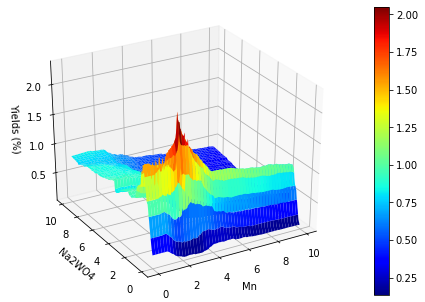

In [6]:
model = opt_ETR(n_estimators = 500, random_state = 1126)
model.fit(feat, target)
want_pred, sigma = model.predict(want, return_std = True)
ind = want_pred.argmax()
cur_max = want_pred[ind]
want_pred = pd.DataFrame(want_pred)
ei_ = pd.DataFrame(EI(pd.DataFrame(want_pred), pd.DataFrame(sigma), cur_max))

fig = plt.figure()
ax = Axes3D(fig, azim = 240)
ei = np.array(ei_).reshape(200,200)
x = np.arange(0, 10, 0.05)
y = np.arange(0, 10, 0.05)
x, y = np.meshgrid(y, x)
ax.set_xlabel('Mn')
ax.set_ylabel('Na2WO4')
ax.set_zlabel('Yields (%)')
surf = ax.plot_surface(x, y, ei, cmap = plt.cm.jet, linewidth = 240)
np.savetxt("out/pdp/ei_Mn_W.csv", ei, delimiter=",")
np.savetxt('out/pdp/ei_Mn.csv', x, delimiter =',')
np.savetxt("out/pdp/ei_W.csv", y, delimiter=",")

plt.colorbar(surf)

In [17]:
ei_.loc[:, "x"] = x.flatten()
ei_.loc[:, "y"] = y.flatten()
ei_

,0,x,y
0,0.242356,0.00,0.00
1,0.242356,0.05,0.00
2,0.242356,0.10,0.00
3,0.242356,0.15,0.00
4,0.242356,0.20,0.00
...,...,...,...
39995,0.400123,9.75,9.95
39996,0.400123,9.80,9.95
39997,0.400123,9.85,9.95
39998,0.389374,9.90,9.95


In [23]:
idx =ei_.iloc[:, 0] > 2.0
ei_ = ei_[idx]

In [24]:
ei_.describe()

,0,x,y
count,22.000000,22.000000,22.000000
mean,2.102167,2.315909,0.943182
std,0.089859,0.129455,0.054106
min,2.004899,2.150000,0.800000
25%,2.030085,2.200000,0.900000
50%,2.079689,2.300000,0.950000
75%,2.156994,2.400000,1.000000
max,2.337674,2.650000,1.000000


In [21]:
idx = (ei_ >1 )
